In [17]:
import sys
sys.path.append('nngp')

import numpy as np
import tensorflow as tf
import pandas as pd

from sklearn.datasets import load_boston
from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from nngp.nngp import NNGPKernel
from nngp.gpr import GaussianProcessRegression

from matplotlib import cm
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
"""Interpolate in NNGP grid.
"""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf


def interp_lin(x, y, xp, log_spacing=False):
    """Linearly interpolate.

    x is evenly spaced grid coordinates, with values y,
    xp are the locations to which to interpolate.
    x and xp must be 1d tensors.
    """
    with tf.name_scope('interp_lin'):
        if log_spacing:
            x = tf.log(x)
            xp = tf.log(xp)

        spacing = x[1] - x[0]
        grid = (xp - x[0]) / spacing
        ind1 = tf.cast(grid, tf.int32)
        ind2 = ind1 + 1
        max_ind = x.shape[0].value
        # set top and bottom indices identical if extending past end of range
        ind2 = tf.minimum(max_ind - 1, ind2)

        weight1 = tf.abs(xp - tf.gather(x, ind1)) / spacing
        weight2 = tf.abs(xp - tf.gather(x, ind2)) / spacing
        if log_spacing:
            weight1 = tf.exp(weight1)
            weight2 = tf.exp(weight2)

        weight1 = 1. - tf.reshape(weight1, [-1] + [1] * (len(y.shape) - 1))
        weight2 = 1. - tf.reshape(weight2, [-1] + [1] * (len(y.shape) - 1))

        weight_sum = weight1 + weight2
        weight1 /= weight_sum
        weight2 /= weight_sum

        y1 = tf.gather(y, ind1)
        y2 = tf.gather(y, ind2)
        yp = y1 * weight1 + y2 * weight2
        return yp


def _get_interp_idxs_weights_2d(x, xp, y, yp, x_log_spacing=False):
    with tf.name_scope('get_interp_idxs_weights_2d'):
        if x_log_spacing:
            x = tf.log(x)
            xp = tf.log(xp)

        with tf.control_dependencies([yp]):
            xp = tf.tile(xp, yp.shape)
        xyp = tf.expand_dims(tf.parallel_stack([xp, yp]), 1)
        xy0 = tf.reshape(tf.parallel_stack([x[0], y[0]]), [2, 1, 1])
        xy1 = tf.reshape(tf.parallel_stack([x[1], y[1]]), [2, 1, 1])

        spacing = xy1 - xy0
        ind_grid = (xyp - xy0) / spacing
        ind = tf.cast(ind_grid, tf.int32) + [[[0], [1]]]

        max_ind = [[[x.shape[0].value - 1]], [[y.shape[0].value - 1]]]
        ind = tf.minimum(ind, max_ind)
        ind_float = tf.cast(ind, tf.float64)

        xy_grid = ind_float * spacing + xy0

        weight = tf.abs(xyp - xy_grid) / spacing
        if x_log_spacing:
            weight = tf.parallel_stack([tf.exp(weight[0]), weight[1]])
        weight = 1. - weight

        weight_sum = tf.reduce_sum(weight, axis=1, keep_dims=True)
        weight /= weight_sum

        return ind, weight


def interp_lin_2d(x, y, z, xp, yp, x_log_spacing=False):
    with tf.name_scope('interp_lin_2d'):
        ind, weight = _get_interp_idxs_weights_2d(x, xp, y, yp, x_log_spacing)
        zp_accum = 0.

        for ind_x, weight_x in [(ind[0, 0], weight[0, 0]),
                                (ind[0, 1], weight[0, 1])]:
            for ind_y, weight_y in [(ind[1, 0], weight[1, 0]),
                                    (ind[1, 1], weight[1, 1])]:
                zp = tf.gather_nd(z, tf.stack([ind_x, ind_y], axis=1))
                zp_accum += zp * weight_x * weight_y

        return zp_accum


In [3]:
"""Neural Network Gaussian Process (nngp) kernel computation.

Implementaion based on
"Deep Neural Networks as Gaussian Processes" by
Jaehoon Lee, Yasaman Bahri, Roman Novak, Samuel S. Schoenholz,
Jeffrey Pennington, Jascha Sohl-Dickstein
arXiv:1711.00165 (https://arxiv.org/abs/1711.00165).
"""
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import multiprocessing
import os

import numpy as np
import tensorflow as tf

import interp


class NNGPKernel(object):
    """The iterative covariance Kernel for Neural Network Gaussian Process.

  Args:
    depth: int, number of hidden layers in corresponding NN.
    nonlin_fn: tf ops corresponding to point-wise non-linearity in corresponding
      NN. e.g.) tf.nn.relu, tf.nn.sigmoid, lambda x: x * tf.nn.sigmoid(x), ...
    weight_var: initial value for the weight_variances parameter.
    bias_var: initial value for the bias_variance parameter.
    n_gauss: Number of gaussian integration grid. Choose odd integer, so that
      there is a gridpoint at 0.
    n_var: Number of variance grid points.
    n_corr: Number of correlation grid points.
    use_fixed_point_norm: bool, normalize input to variance fixed point.
      Defaults to False, normalizing input to unit norm over input dimension.
  """

    def __init__(self,
                 depth=1,
                 nonlin_fn=tf.tanh,
                 weight_var=1.,
                 bias_var=1.,
                 n_gauss=101,
                 n_var=151,
                 n_corr=131,
                 max_var=100,
                 max_gauss=100,
                 use_fixed_point_norm=False,
                 fraction_of_int32=32,
                 use_precomputed_grid=False,
                 grid_path=None,
                 sess=None):
        self.depth = depth
        self.weight_var = weight_var
        self.bias_var = bias_var
        self.use_fixed_point_norm = use_fixed_point_norm
        self.sess = sess
        self.fraction_of_int32 = fraction_of_int32
        self.use_precomputed_grid = use_precomputed_grid

        if use_precomputed_grid and (grid_path is None):
            raise ValueError("grid_path must be specified to use precomputed grid.")
        self.grid_path = grid_path

        self.nonlin_fn = nonlin_fn
        (self.var_aa_grid, self.corr_ab_grid, self.qaa_grid,
         self.qab_grid) = self.get_grid(n_gauss, n_var, n_corr, max_var, max_gauss)

        if self.use_fixed_point_norm:
            self.var_fixed_point_np, self.var_fixed_point = self.get_var_fixed_point()

    def get_grid(self, n_gauss, n_var, n_corr, max_var, max_gauss):
        """Get covariance grid by loading or computing a new one.
    """
        # File configuration for precomputed grid
        if self.use_precomputed_grid:
            grid_path = self.grid_path
            # TODO(jaehlee) np.save have broadcasting error when n_var==n_corr.
            if n_var == n_corr:
                n_var += 1
            grid_file_name = "grid_{0:s}_ng{1:d}_ns{2:d}_nc{3:d}".format(
                self.nonlin_fn.__name__, n_gauss, n_var, n_corr)
            grid_file_name += "_mv{0:d}_mg{1:d}".format(max_var, max_gauss)

        # Load grid file if it exists already
        if (self.use_precomputed_grid and
                tf.gfile.Exists(os.path.join(grid_path, grid_file_name))):
            with tf.gfile.Open(os.path.join(grid_path, grid_file_name), "rb") as f:
                grid_data_np = np.load(f)
                tf.logging.info("Loaded interpolation grid from %s" %
                                os.path.join(grid_path, grid_file_name))
                grid_data = (tf.convert_to_tensor(grid_data_np[0], dtype=tf.float64),
                             tf.convert_to_tensor(grid_data_np[1], dtype=tf.float64),
                             tf.convert_to_tensor(grid_data_np[2], dtype=tf.float64),
                             tf.convert_to_tensor(grid_data_np[3], dtype=tf.float64))

        else:
            tf.logging.info("Generating interpolation grid...")
            grid_data = _compute_qmap_grid(self.nonlin_fn, n_gauss, n_var, n_corr,
                                           max_var=max_var, max_gauss=max_gauss)
            if self.use_precomputed_grid:
                with tf.Session() as sess:
                    grid_data_np = sess.run(grid_data)
                tf.gfile.MakeDirs(grid_path)
                with tf.gfile.Open(os.path.join(grid_path, grid_file_name), "wb") as f:
                    np.save(f, grid_data_np)

                with tf.gfile.Open(os.path.join(grid_path, grid_file_name), "rb") as f:
                    grid_data_np = np.load(f)
                    tf.logging.info("Loaded interpolation grid from %s" %
                                    os.path.join(grid_path, grid_file_name))
                    grid_data = (tf.convert_to_tensor(grid_data_np[0], dtype=tf.float64),
                                 tf.convert_to_tensor(grid_data_np[1], dtype=tf.float64),
                                 tf.convert_to_tensor(grid_data_np[2], dtype=tf.float64),
                                 tf.convert_to_tensor(grid_data_np[3], dtype=tf.float64))

        return grid_data

    def get_var_fixed_point(self):
        with tf.name_scope("get_var_fixed_point"):
            # If normalized input length starts at 1.
            current_qaa = self.weight_var * tf.constant(
                [1.], dtype=tf.float64) + self.bias_var

            diff = 1.
            prev_qaa_np = 1.
            it = 0
            while diff > 1e-6 and it < 300:
                samp_qaa = interp.interp_lin(
                    self.var_aa_grid, self.qaa_grid, current_qaa)
                samp_qaa = self.weight_var * samp_qaa + self.bias_var
                current_qaa = samp_qaa

                with tf.Session() as sess:
                    current_qaa_np = sess.run(current_qaa)
                diff = np.abs(current_qaa_np - prev_qaa_np)
                it += 1
                prev_qaa_np = current_qaa_np
            return current_qaa_np, current_qaa

    def k_diag(self, input_x, return_full=True):
        """Iteratively building the diagonal part (variance) of the NNGP kernel.

    Args:
      input_x: tensor of input of size [num_data, input_dim].
      return_full: boolean for output to be [num_data] sized or a scalar value
        for normalized inputs

    Sets self.layer_qaa_dict of {layer #: qaa at the layer}

    Returns:
      qaa: variance at the output.
    """
        with tf.name_scope("Kdiag"):
            # If normalized input length starts at 1.
            if self.use_fixed_point_norm:
                current_qaa = self.var_fixed_point
            else:
                current_qaa = self.weight_var * tf.convert_to_tensor(
                    [1.], dtype=tf.float64) + self.bias_var
            self.layer_qaa_dict = {0: current_qaa}
            for l in range(self.depth):
                with tf.name_scope("layer_%d" % l):
                    samp_qaa = interp.interp_lin(
                        self.var_aa_grid, self.qaa_grid, current_qaa)
                    samp_qaa = self.weight_var * samp_qaa + self.bias_var
                    self.layer_qaa_dict[l + 1] = samp_qaa
                    current_qaa = samp_qaa

            if return_full:
                qaa = tf.tile(current_qaa[:1], ([input_x.shape[0].value]))
            else:
                qaa = current_qaa[0]
            return qaa

    def k_full(self, input1, input2=None):
        """Iteratively building the full NNGP kernel.
    """
        input1 = self._input_layer_normalization(input1)
        if input2 is None:
            input2 = input1
        else:
            input2 = self._input_layer_normalization(input2)

        with tf.name_scope("k_full"):
            cov_init = tf.matmul(
                input1, input2, transpose_b=True) / input1.shape[1].value

            self.k_diag(input1)
            q_aa_init = self.layer_qaa_dict[0]

            q_ab = cov_init
            q_ab = self.weight_var * q_ab + self.bias_var
            corr = q_ab / q_aa_init[0]

            if self.fraction_of_int32 > 1:
                batch_size, batch_count = self._get_batch_size_and_count(input1, input2)
                with tf.name_scope("q_ab"):
                    q_ab_all = []
                    for b_x in range(batch_count):
                        with tf.name_scope("batch_%d" % b_x):
                            corr_flat_batch = corr[
                                              batch_size * b_x: batch_size * (b_x + 1), :]
                            corr_flat_batch = tf.reshape(corr_flat_batch, [-1])

                            for l in range(self.depth):
                                with tf.name_scope("layer_%d" % l):
                                    q_aa = self.layer_qaa_dict[l]
                                    q_ab = interp.interp_lin_2d(x=self.var_aa_grid,
                                                                y=self.corr_ab_grid,
                                                                z=self.qab_grid,
                                                                xp=q_aa,
                                                                yp=corr_flat_batch)

                                    q_ab = self.weight_var * q_ab + self.bias_var
                                    corr_flat_batch = q_ab / self.layer_qaa_dict[l + 1][0]

                            q_ab_all.append(q_ab)

                    q_ab_all = tf.parallel_stack(q_ab_all)
            else:
                with tf.name_scope("q_ab"):
                    corr_flat = tf.reshape(corr, [-1])
                    for l in range(self.depth):
                        with tf.name_scope("layer_%d" % l):
                            q_aa = self.layer_qaa_dict[l]
                            q_ab = interp.interp_lin_2d(x=self.var_aa_grid,
                                                        y=self.corr_ab_grid,
                                                        z=self.qab_grid,
                                                        xp=q_aa,
                                                        yp=corr_flat)
                            q_ab = self.weight_var * q_ab + self.bias_var
                            corr_flat = q_ab / self.layer_qaa_dict[l + 1][0]
                        q_ab_all = q_ab

        return tf.reshape(q_ab_all, cov_init.shape, "qab")

    def _input_layer_normalization(self, x):
        """Input normalization to unit variance or fixed point variance.
    """
        with tf.name_scope("input_layer_normalization"):
            # Layer norm, fix to unit variance
            eps = 1e-15
            mean, var = tf.nn.moments(x, axes=[1], keep_dims=True)
            x_normalized = (x - mean) / tf.sqrt(var + eps)
            if self.use_fixed_point_norm:
                x_normalized *= tf.sqrt(
                    (self.var_fixed_point[0] - self.bias_var) / self.weight_var)
            return x_normalized

    def _get_batch_size_and_count(self, input1, input2):
        """Compute batch size and number to split when input size is large.

    Args:
      input1: tensor, input tensor to covariance matrix
      input2: tensor, second input tensor to covariance matrix

    Returns:
      batch_size: int, size of each batch
      batch_count: int, number of batches
    """
        input1_size = input1.shape[0].value
        input2_size = input2.shape[0].value

        batch_size = min(np.iinfo(np.int32).max // (self.fraction_of_int32 * input2_size), input1_size)
        while input1_size % batch_size != 0:
            batch_size -= 1

        batch_count = input1_size // batch_size
        return batch_size, batch_count


def _fill_qab_slice(idx, z1, z2, var_aa, corr_ab, nonlin_fn):
    """Helper method used for parallel computation for full qab."""
    log_weights_ab_unnorm = -(z1 ** 2 + z2 ** 2 - 2 * z1 * z2 * corr_ab) / (
            2 * var_aa[idx] * (1 - corr_ab ** 2))
    log_weights_ab = log_weights_ab_unnorm - tf.reduce_logsumexp(
        log_weights_ab_unnorm, axis=[0, 1], keep_dims=True)
    weights_ab = tf.exp(log_weights_ab)

    qab_slice = tf.reduce_sum(
        nonlin_fn(z1) * nonlin_fn(z2) * weights_ab, axis=[0, 1])
    qab_slice = tf.Print(qab_slice, [idx], "Generating slice: ")
    return qab_slice


def _compute_qmap_grid(nonlin_fn,
                       n_gauss,
                       n_var,
                       n_corr,
                       log_spacing=False,
                       min_var=1e-8,
                       max_var=100.,
                       max_corr=0.99999,
                       max_gauss=10.):
    """Construct graph for covariance grid to use for kernel computation.

  Given variance and correlation (or covariance) of pre-activation, perform
  Gaussian integration to get covariance of post-activation.

  Raises:
    ValueError: if n_gauss is even integer.

  Args:
    nonlin_fn: tf ops corresponding to point-wise non-linearity in
      corresponding NN. e.g.) tf.nn.relu, tf.nn.sigmoid,
      lambda x: x * tf.nn.sigmoid(x), ...
    n_gauss: int, number of Gaussian integration points with equal spacing
      between (-max_gauss, max_gauss). Choose odd integer, so that there is a
      gridpoint at 0.
    n_var: int, number of variance grid points.get_grid
    n_corr: int, number of correlation grid points.
    log_spacing: bool, whether to use log-linear instead of linear variance
      grid.
    min_var: float, smallest variance value to generate grid.
    max_var: float, largest varaince value to generate grid.
    max_corr: float, largest correlation value to generate grid. Should be
      slightly smaller than 1.
    max_gauss: float, range (-max_gauss, max_gauss) for Gaussian integration.

  Returns:
    var_grid_pts: tensor of size [n_var], grid points where variance are
      evaluated at.
    corr_grid_pts: tensor of size [n_corr], grid points where correlation are
      evalutated at.
    qaa: tensor of size [n_var], variance of post-activation at given
      pre-activation variance.
    qab: tensor of size [n_var, n_corr], covariance of post-activation at
      given pre-activation variance and correlation.
  """
    if n_gauss % 2 != 1:
        raise ValueError("n_gauss=%d should be an odd integer" % n_gauss)

    with tf.name_scope("compute_qmap_grid"):
        min_var = tf.convert_to_tensor(min_var, dtype=tf.float64)
        max_var = tf.convert_to_tensor(max_var, dtype=tf.float64)
        max_corr = tf.convert_to_tensor(max_corr, dtype=tf.float64)
        max_gauss = tf.convert_to_tensor(max_gauss, dtype=tf.float64)

        # Evaluation points for numerical integration over a Gaussian.
        z1 = tf.reshape(tf.linspace(-max_gauss, max_gauss, n_gauss), (-1, 1, 1))
        z2 = tf.transpose(z1, perm=[1, 0, 2])

        if log_spacing:
            var_aa = tf.exp(tf.linspace(tf.log(min_var), tf.log(max_var), n_var))
        else:
            # Evaluation points for pre-activations variance and correlation
            var_aa = tf.linspace(min_var, max_var, n_var)
        corr_ab = tf.reshape(tf.linspace(-max_corr, max_corr, n_corr), (1, 1, -1))

        # compute q_aa
        log_weights_aa_unnorm = -0.5 * (z1 ** 2 / tf.reshape(var_aa, [1, 1, -1]))
        log_weights_aa = log_weights_aa_unnorm - tf.reduce_logsumexp(
            log_weights_aa_unnorm, axis=[0, 1], keep_dims=True)
        weights_aa = tf.exp(log_weights_aa)
        qaa = tf.reduce_sum(nonlin_fn(z1) ** 2 * weights_aa, axis=[0, 1])

        # compute q_ab
        # weights to reweight uniform samples by, for q_ab.
        # (weights are probability of z1, z2 under Gaussian
        #  w/ variance var_aa and covariance var_aa*corr_ab)
        # weights_ab will have shape [n_g, n_g, n_v, n_c]
        def fill_qab_slice(idx):
            return _fill_qab_slice(idx, z1, z2, var_aa, corr_ab, nonlin_fn)

        qab = tf.map_fn(
            fill_qab_slice,
            tf.range(n_var),
            dtype=tf.float64,
            parallel_iterations=multiprocessing.cpu_count())

        var_grid_pts = tf.reshape(var_aa, [-1])
        corr_grid_pts = tf.reshape(corr_ab, [-1])

        return var_grid_pts, corr_grid_pts, qaa, qab


In [4]:
"""Gaussian process regression model based on GPflow.
"""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import time

import tensorflow as tf


class GaussianProcessRegression(object):
    """Gaussian process regression model based on GPflow.

    Args:
      input_x: numpy array, [data_size, input_dim]
      output_x: numpy array, [data_size, output_dim]
      kern: NNGPKernel class
    """

    def __init__(self, input_x, output_y, kern, print_kernel=False):
        with tf.name_scope("init"):
            self.input_x = input_x
            self.output_y = output_y
            self.num_train, self.input_dim = input_x.shape
            _, self.output_dim = output_y.shape

            self.kern = kern
            self.print_kernel = print_kernel
            self.stability_eps = tf.identity(tf.placeholder(tf.float64))
            self.current_stability_eps = 1e-10

            self.y_pl = tf.placeholder(tf.float64, [self.num_train, self.output_dim], name="y_train")
            self.x_pl = tf.identity(tf.placeholder(tf.float64, [self.num_train, self.input_dim], name="x_train"))

            self.l_np = None
            self.v_np = None
            self.k_np = None

        self.k_data_data = tf.identity(self.kern.k_full(self.x_pl))

    def _build_predict(self, n_test, full_cov=False):
        with tf.name_scope("build_predict"):
            self.x_test_pl = tf.identity(
                tf.placeholder(tf.float64, [n_test, self.input_dim], name="x_test_pl")
            )

        tf.logging.info("Using pre-computed Kernel")
        self.k_data_test = self.kern.k_full(self.x_pl, self.x_test_pl)

        with tf.name_scope("build_predict"):
            a = tf.matrix_triangular_solve(self.l, self.k_data_test)
            fmean = tf.matmul(a, self.v, transpose_a=True)

            if full_cov:
                fvar = self.kern.k_full(self.x_test_pl) - tf.matmul(
                    a, a, transpose_a=True)
                shape = [1, 1, self.y_pl.shape[1]]
                fvar = tf.tile(tf.expand_dims(fvar, 2), shape)
            else:
                fvar = self.kern.k_diag(self.x_test_pl) - tf.reduce_sum(tf.square(a), 0)
                fvar = tf.tile(tf.reshape(fvar, (-1, 1)), [1, self.output_y.shape[1]])

            self.fmean = fmean
            self.fvar = fvar

    def _build_cholesky(self):
        tf.logging.info("Computing Kernel")
        self.k_data_data_reg = self.k_data_data + tf.eye(
            self.input_x.shape[0], dtype=tf.float64) * self.stability_eps
        if self.print_kernel:
            self.k_data_data_reg = tf.Print(
                self.k_data_data_reg, [self.k_data_data_reg],
                message="K_DD = ", summarize=100)
        self.l = tf.cholesky(self.k_data_data_reg)
        self.v = tf.matrix_triangular_solve(self.l, self.y_pl)

    def predict(self, test_x, sess, get_var=False):
        """Compute mean and varaince prediction for test inputs.

        Raises:
          ArithmeticError: Cholesky fails even after increasing to large values of
            stability epsilon.
        """
        if self.l_np is None:
            self._build_cholesky()
            start_time = time.time()
            self.k_np = sess.run(self.k_data_data,
                                 feed_dict={self.x_pl: self.input_x})
            tf.logging.info("Computed K_DD in %.3f secs" % (time.time() - start_time))

            while self.current_stability_eps < 1:
                try:
                    start_time = time.time()
                    self.l_np, self.v_np = sess.run(
                        [self.l, self.v],
                        feed_dict={self.y_pl: self.output_y,
                                   self.k_data_data: self.k_np,
                                   self.stability_eps: self.current_stability_eps})
                    tf.logging.info(
                        "Computed L_DD in %.3f secs" % (time.time() - start_time))
                    break

                except tf.errors.InvalidArgumentError:
                    self.current_stability_eps *= 10
                    tf.logging.info("Cholesky decomposition failed, trying larger epsilon"
                                    ": {}".format(self.current_stability_eps))

        if self.current_stability_eps > 0.2:
            raise ArithmeticError("Could not compute Cholesky decomposition.")

        n_test = test_x.shape[0]
        self._build_predict(n_test)
        feed_dict = {
            self.x_pl: self.input_x,
            self.x_test_pl: test_x,
            self.l: self.l_np,
            self.v: self.v_np
        }

        start_time = time.time()
        if get_var:
            mean_pred, var_pred = sess.run(
                [self.fmean, self.fvar], feed_dict=feed_dict)
            tf.logging.info("Did regression in %.3f secs" % (time.time() - start_time))
            return mean_pred, var_pred, self.current_stability_eps

        else:
            mean_pred = sess.run(self.fmean, feed_dict=feed_dict)
            tf.logging.info("Did regression in %.3f secs" % (time.time() - start_time))
            return mean_pred, self.current_stability_eps


In [5]:
sys.path.append('nngp')
boston = load_boston()

# split into test and training data
X_train, X_test, y_train, y_test = train_test_split(boston.data, boston.target, random_state=444, test_size=.25)
# scale each predictor to be zero mean and unit variance
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
y_train = y_train.reshape(-1, 1)
# don't leak into test data
X_test = scaler.transform(X_test)
y_test = y_test.reshape(-1, 1)

with tf.Session() as sess:
    nngp_kernel = NNGPKernel(
        depth=10,
        weight_var=1.79,
        bias_var=0.83,
        nonlin_fn=tf.tanh,
        grid_path='grid',
        use_precomputed_grid=True,
        n_gauss=501,
        n_var=501,
        n_corr=501,
        max_gauss=10,
        max_var=100,
        use_fixed_point_norm=False)

    model = GaussianProcessRegression(X_train, y_train, kern=nngp_kernel)
    y_hat_train, train_eps = model.predict(X_train, sess)
    y_hat_test, test_eps = model.predict(X_test, sess)

print('Training MSE: %.3f, R2: %.3f' % (mean_squared_error(y_train, y_hat_train), r2_score(y_train, y_hat_train)))

print('Test MSE: %.3f, R2: %.3f' % (mean_squared_error(y_test, y_hat_test), r2_score(y_test, y_hat_test)))

INFO:tensorflow:Loaded interpolation grid from grid/grid_tanh_ng501_ns502_nc501_mv100_mg10
Instructions for updating:
keep_dims is deprecated, use keepdims instead
INFO:tensorflow:Computing Kernel
INFO:tensorflow:Computed K_DD in 1.756 secs
INFO:tensorflow:Cholesky decomposition failed, trying larger epsilon: 1e-09
INFO:tensorflow:Cholesky decomposition failed, trying larger epsilon: 1e-08
INFO:tensorflow:Cholesky decomposition failed, trying larger epsilon: 1e-07
INFO:tensorflow:Cholesky decomposition failed, trying larger epsilon: 1e-06
INFO:tensorflow:Cholesky decomposition failed, trying larger epsilon: 9.999999999999999e-06
INFO:tensorflow:Cholesky decomposition failed, trying larger epsilon: 9.999999999999999e-05
INFO:tensorflow:Computed L_DD in 0.006 secs
INFO:tensorflow:Using pre-computed Kernel
INFO:tensorflow:Did regression in 2.634 secs
INFO:tensorflow:Using pre-computed Kernel
INFO:tensorflow:Did regression in 1.906 secs
Training MSE: 1.323, R2: 0.984
Test MSE: 11.940, R2: 

In [6]:
mnist = fetch_mldata('MNIST original', data_home='mnist')
mnist.DESCR

'mldata.org dataset: mnist-original'

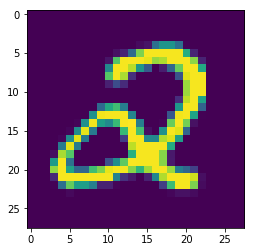

In [7]:
plt.imshow(mnist.data[np.random.choice(mnist.data.shape[0])].reshape((28, 28)));

In [8]:
lb = LabelBinarizer()
lb.fit(mnist.target)
# encode target labels as zero-mean one hot encoded vector 
# with negative class = -0.1 and positive class as 0.9
encode = lambda y: lb.transform(y) - .1

In [9]:
image_train, image_test, label_train, label_test = train_test_split(
    mnist.data, mnist.target, stratify = mnist.target, random_state = 444, test_size=.15)

X_test = image_test
y_test = encode(label_test)

In [10]:
def get_train_subset(n):
    x, _, y, _ = train_test_split(image_train, label_train, stratify = label_train, random_state=333, train_size = n)
    return x, encode(y)

def do_experiment(nn_width, samle_size):
    X_train, y_train = get_train_subset(samle_size)
    nnr = NNR(784, 10, hidden_dim = 256, hidden_layers = nn_width)
    nnr.fit(X_train, y_train)
    y_hat = nnr.predict(X_test)
    return nnr.accuracy(y_test, y_hat), nnr.mean_squared_error(y_test, y_hat)

def do_nngp_experiment(layers, sample_size):
    X_train, y_train = get_train_subset(sample_size)
    with tf.Session() as sess:
        nngp_kernel = NNGPKernel(
            depth=layers,
            weight_var=1.79,
            bias_var=0.83,
            nonlin_fn=tf.tanh,
            grid_path='grid',
            use_precomputed_grid=True,
            n_gauss=501,
            n_var=501,
            n_corr=501,
            max_gauss=10,
            max_var=100,
            use_fixed_point_norm=False)

        model = GaussianProcessRegression(X_train, y_train, kern=nngp_kernel)
        y_hat, test_eps = model.predict(X_test, sess)

    return mean_squared_error(y_test, y_hat), r2_score(y_test, y_hat)

In [11]:
sample_sizes = np.array([500, 1000, 5000])
#sample_sizes = np.array([1000, 5000, 20000, 50000])
hidden_depths = np.array([5, 10, 20])
results = np.empty((sample_sizes.shape[0], hidden_depths.shape[0], 2))
columns = ['Hidden Layers', 'Sample Size', 'MSE', 'R2']
results_df = pd.DataFrame(columns=columns)

for i, sample_size in enumerate(sample_sizes):
    for j, depth in enumerate(hidden_depths):
        results[i, j, 0],  results[i, j, 1] = do_nngp_experiment(layers=depth, sample_size=sample_size)
        mse_result, r2_result = do_nngp_experiment(layers=depth, sample_size=sample_size)
        results_df = pd.concat([results_df, pd.DataFrame([[depth, sample_size, mse_result, r2_result]], columns=columns)], ignore_index=True)

INFO:tensorflow:Loaded interpolation grid from grid/grid_tanh_ng501_ns502_nc501_mv100_mg10


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


INFO:tensorflow:Computing Kernel
INFO:tensorflow:Computed K_DD in 4.827 secs
INFO:tensorflow:Computed L_DD in 0.095 secs
INFO:tensorflow:Using pre-computed Kernel
INFO:tensorflow:Did regression in 16.273 secs
INFO:tensorflow:Loaded interpolation grid from grid/grid_tanh_ng501_ns502_nc501_mv100_mg10
INFO:tensorflow:Computing Kernel
INFO:tensorflow:Computed K_DD in 5.763 secs
INFO:tensorflow:Computed L_DD in 0.095 secs
INFO:tensorflow:Using pre-computed Kernel
INFO:tensorflow:Did regression in 32.228 secs
INFO:tensorflow:Loaded interpolation grid from grid/grid_tanh_ng501_ns502_nc501_mv100_mg10
INFO:tensorflow:Computing Kernel
INFO:tensorflow:Computed K_DD in 13.021 secs
INFO:tensorflow:Cholesky decomposition failed, trying larger epsilon: 1e-09
INFO:tensorflow:Cholesky decomposition failed, trying larger epsilon: 1e-08
INFO:tensorflow:Cholesky decomposition failed, trying larger epsilon: 1e-07
INFO:tensorflow:Cholesky decomposition failed, trying larger epsilon: 1e-06
INFO:tensorflow:Ch

[]

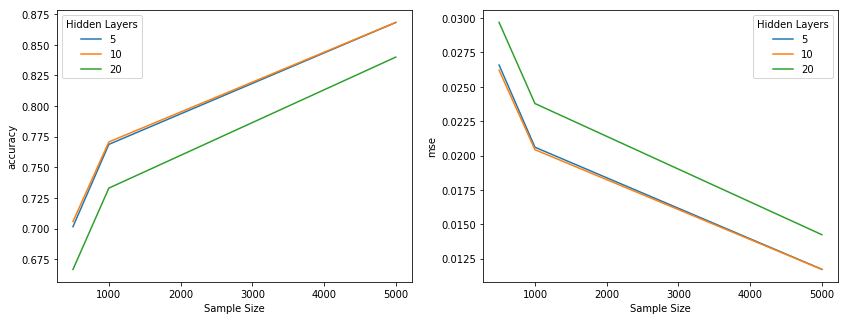

In [38]:
plt.figure(figsize = (14, 5))
ax1 = plt.subplot(121)
results_df.pivot(index='Sample Size', columns='Hidden Layers', values='R2').plot(ax=ax1)
#plt.plot(sample_sizes, results[:, 0])
#plt.xlabel('sample size')
plt.ylabel('accuracy')
ax2 = plt.subplot(122)
results_df.pivot(index='Sample Size', columns='Hidden Layers', values='MSE').plot(ax=ax2)
#plt.plot(sample_sizes, results[:, 1])
#plt.xlabel('sample size')
plt.ylabel('mse')
plt.plot()